In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import warnings

## Задача 2.1

Сгенерируйте набор признаков $X$ — двумерный массив размера $(1000 \times 1)$, состоящий из случайных вещественных чисел, равномерно распределённых по промежутку $[-1,\;2)$. Затем получите набор меток $y$ — одномерный массив размера $1000$, — по формуле:
$$
y = 3x - 8x^2 + 6x^3.
$$
Подсказка: может помочь `numpy.random.uniform`

Полностью векторизуйте решение, то есть избегайте явного использования циклов.

азделите $X, y$ случайным образом на два фрагмента в соотношении $100 \div 900$. Удалите из первого фрагмента пары, в которых $x$ лежит за пределами отрезка $[0, 1]$. Первый фрагмент мы далее будем называть тренировочным, второй — валидационным.

Подсказка: может помочь `numpy.random.choice`

Оформите решение в виде функции, придерживаясь приведенного ниже шаблона.Рассмотрите случаи, когда в вашу функцию `train_val_split` могут быть поданы на вход некорректные данные. Добавьте обработку таких случаев. Полностью векторизуйте решение.

Добавьте к тренировочным значениям $y$ случайный гауссов шум со стандартным отклонением $0.1$.

Валидационные значения меток оставьте без изменений. Полностью векторизуйте решение.

Изобразите получившийся датасет на графике. Подпишите оси, выберите подходящий диапазон значений осей. Раскрасьте в разные цвета точки из разных фрагментов датасета. Подпишите цвета на легенде графика

In [ ]:
# Задаём размер выборки
n_samples = 1000

# Генерируем набор признаков X: 1000 случайных чисел из [-1, 2)
X = np.random.uniform(low=-1, high=2, size=(n_samples, 1))

# Вычисляем метки y по формуле: y = 3x - 8x^2 + 6x^3
y = 3 * X - 8 * X**2 + 6 * X**3

# Преобразуем y в одномерный массив (1000,)
y = y.ravel()

In [ ]:
print(X[:10])

[[ 0.62401429]
 [ 0.76652608]
 [ 1.45943056]
 [ 0.08265876]
 [ 0.83399724]
 [ 0.99652804]
 [ 0.57999292]
 [-0.22116816]
 [ 1.45639874]
 [ 0.2942853 ]]


In [ ]:
print(y[:10])

[ 0.2148161   0.30137103  5.98976694  0.1967051   0.41810822  0.98276049
  0.21947359 -1.11973841  5.93539841  0.34294262]


In [ ]:
def train_val_split(
      X:np.ndarray,
      y:np.ndarray,
      train_fraction:float=0.1,
      train_size:int=None,
      random_state:int=42,
    )->tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:

    """
    X : numpy.ndarray (n_samples, n_features) - массив признаков
    y : numpy.ndarray (n_samples) - массив меток

    train_fraction : optional, float - доля объектов, которую
    нужно отправить в тренировочную выборку
    аргумент игнорируется, если задан train_size

    train_size : optional, int - число объектов, которое
    нужно отправить в тренировочную выборку

    random_state : optional, int - аргумент,
    передаваемый генераторам случайных чисел
    (используется для воспроизводимости результатов)
    """

    if not isinstance(X, np.ndarray) or not isinstance(y, np.ndarray):
        raise TypeError("X и y должны быть numpy.ndarray")

    if X.size == 0 or y.size == 0:
        raise ValueError("X и y не должны быть пустыми массивами")



    np.random.seed(random_state)
    n_samples = X.shape[0]

    if train_size is None:
        train_size = int(n_samples * train_fraction)

    # Отбирает признаки случайно часть в train, остальное в валидацию
    train_indices = np.random.choice(n_samples, size=train_size, replace=False)
    val_indices = np.setdiff1d(np.arange(n_samples), train_indices)

    # Получаем тренировочный фрагмент
    X_train = X[train_indices]
    y_train = y[train_indices]

    # Делим данные по маске в промежутке от 0 до 1
    mask = (X_train >= 0) & (X_train <= 1)
    mask = mask.ravel()
    # Фильтрация данных по маске
    X_train = X_train[mask]
    y_train = y_train[mask].reshape(-1, 1)

    # Добавляем гауссов шум к тренировочным меткам
    y_train = y_train + np.random.normal(loc=0, scale=0.1, size=y_train.shape)

    # Получаем валидационный фрагмент
    X_val = X[val_indices]
    y_val = y[val_indices].reshape(-1, 1)

    return X_train, y_train, X_val, y_val

In [ ]:
X_train, y_train, X_val, y_val = train_val_split(X, y, train_fraction=0.1, train_size=100, random_state=42)

print("Тренировочный фрагмент (X_train):", X_train.shape)
print("Тренировочный фрагмент (y_train):", y_train.shape)
print("Валидационный фрагмент (X_val):", X_val.shape)
print("Валидационный фрагмент (y_val):", y_val.shape)

Тренировочный фрагмент (X_train): (36, 1)
Тренировочный фрагмент (y_train): (36, 1)
Валидационный фрагмент (X_val): (900, 1)
Валидационный фрагмент (y_val): (900, 1)


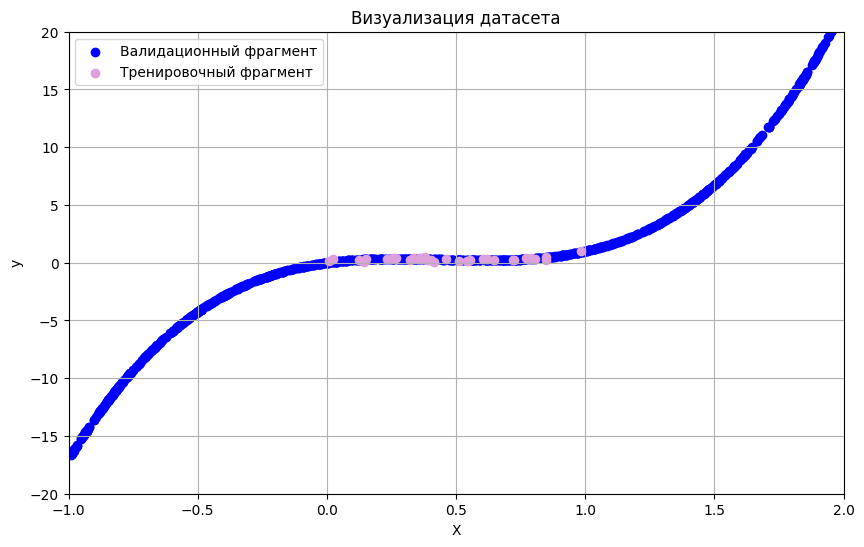

In [ ]:
def plot_dataset(X_train, y_train, X_val, y_val):
    plt.figure(figsize=(10, 6))

    plt.scatter(X_val, y_val, color='blue', label='Валидационный фрагмент')

    # Тренировочные данные
    plt.scatter(X_train, y_train, color='plum', label='Тренировочный фрагмент')

    # Валидационные данные
    plt.xlabel('X')
    plt.ylabel('y')
    plt.title('Визуализация датасета')
    plt.xlim(-1, 2)
    plt.ylim(-20, 20)
    plt.grid(True)
    plt.legend()
    plt.show()

plot_dataset(X_train, y_train, X_val, y_val)

## Задача 2.2

На лекциях была приведена в матричном виде явная формула для системы линейных алгебраических уравнений, которая определяет оптимальные параметры линейной регрессии.

Преобразуйте эту формулу (то есть матрицу системы в левой части и столбец в правой части) для случая полиномиальных признаков, то есть, для признаков
$$ x_1 = x,\quad x_2 = x^2,\quad x_3 = x^3,\quad \dots, \quad x_d = x^d. $$

Запишите ответ в тетради от руки либо в этом блокноте. Для формул можно использовать $\LaTeX$:

В получившейся у вас формуле в столбец в правой части подставьте выражение для $y$ (без учета шума) из Задачи 2.1. Решите аналитически получившуюся систему алгебраических уравнений на параметры $w_0,\,w_1,\,\dots,\,w_d$ для случая $d=3$.  Вычислите аналитически, чему равны средние в пределе бесконечного размера выборки (усредните по распределению сгенерированных вами случайных величин). Запишите решение и ответ в тетради от руки либо в этом блокноте.

Дополните предложенный ниже шаблон класса, который решает задачу линейной регрессии на полиномиальных признаках. Можно пользоваться своими наработками из прошлого семинара. Не забудьте о проверке корректности входных данных.

Перебирая $d$ в диапазоне $\{0,\;1,\;2,\;\dots,\;7\}$, обучите модель для каждого $d$ на тренировочном наборе и вычислите долю объясненной дисперсии обученной модели на тренировочном и валидационном наборе.

Решение полностью векторизовано (кроме перебора моделей с разынми $d$). Решение запускается без ошибок при всех $d$ из списка.

Код универсален, любые корректные $d$ обрабатываются единообразно.

Получена доля объясненной дисперсии на тренировочном и валидационном наборах при всех указанных $d$.

Предусмотрена (в разумных пределах) обработка некорректных входных данных.

Создайте аналог вашей модели `numpyPolyLinearRegression`, используя комбинацию из `sklearn.pipeline.Pipeline`, `sklearn.preprocessing.PolynomialFeatures` и `sklearn.linear_model.LinearRegression`.

Проделайте обучение и оценку качества в том же диапазоне $d$ и сравните результаты.

Выведите на экран оптимальные параметры линейной регрессии для случая $d=3$ в обеих моделях.

Для каждого исследованного $d$ изобразите на одном отдельном графике тренировочный и валидационный наборы точек (разными цветами), а также предсказание обученной вами модели `numpyPolyLinearRegression`. Выберите оптимальный диапазон значений по осям, подпишите оси, точки и линию.

Постройте график зависимости доли объясненной дисперсии от $d$ в изученном вами диапазоне $d$. На одном графике изобразите две линии: для валидационного датасета и для тренировочного. Выберите оптимальный диапазон значений по осям, подпишите оси, точки и линию. Укажите на получившемся графике области under- и overfitting-а.

In [ ]:
class NumpyPolyLR:
    def __init__(self, d: int):
        d = int(d)
        if d < 1:
            raise ValueError("Степень d должна быть целым >= 1.")
        # Инициализация параметров, свободного члена
        self.d = d
        self.coef_ = None
        self.intercept_ = None
        self._fitted = False

    @staticmethod
    # Проверки на корректность данных и их очищение
    def _to_1d_numeric(a, name):
        try:
            x = np.asarray(a, dtype=float).reshape(-1)
        except Exception as e:
            raise ValueError(f"{name}: не удалось привести к числовому массиву (float).") from e
        return x

    def _clean_xy(self, X, y):
        x = self._to_1d_numeric(X, "X")
        y = self._to_1d_numeric(y, "y")
        if x.shape[0] != y.shape[0]:
            raise ValueError(f"Длины X и y не совпадают: {x.shape[0]} vs {y.shape[0]}.")
        if x.size == 0:
            raise ValueError("Пустые данные.")

        mask = np.isfinite(x) & np.isfinite(y)
        if not np.all(mask):
            removed = int((~mask).sum())
            warnings.warn(f"Удалены {removed} некорректных наблюдений (NaN/Inf).", RuntimeWarning)
            x = x[mask]; y = y[mask]

        if x.size < self.d + 1:
            raise ValueError(f"Слишком мало точек после очистки: {x.size}. Нужно >= {self.d+1}.")
        return x, y

    # Инициализация степеней
    def _phi(self, x):
        powers = np.arange(1, self.d + 1, dtype=float)
        return x[:, None] ** powers

    # Обучение модели
    def fit(self, X, y):
        x, y = self._clean_xy(X, y)
        P = self._phi(x)
        A = np.hstack([P, np.ones((P.shape[0], 1))])

        theta, residuals, rank, s = np.linalg.lstsq(A, y, rcond=None)
        if rank < A.shape[1]:
            warnings.warn("Дизайн-матрица вырождена (rank-deficient). Решение найдено в смысле МНК.", RuntimeWarning)

        self.coef_ = theta[:-1]
        self.intercept_ = float(theta[-1])
        self._fitted = True
        return self

    def predict(self, X):
        if not self._fitted:
            raise RuntimeError("Модель не обучена. Сначала вызовите .fit(X, y).")
        x = self._to_1d_numeric(X, "X")
        P = self._phi(x)
        return P @ self.coef_ + self.intercept_

In [ ]:
# Аналог модели толькло с sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

degrees = range(1, 9+1)
curves = {}
metrics = []  # (lib, d, rmse_tr, rmse_v)

def rmse(a,b):
    a=np.asarray(a); b=np.asarray(b)
    return float(np.sqrt(np.mean((a-b)**2)))

grid = np.linspace(X.min(), X.max(), 300).reshape(-1,1)

for d in degrees:
    m = NumpyPolyLR(d).fit(X_train, y_train)
    ytr = m.predict(X_train); yv = m.predict(X_val)
    metrics.append(('numpy', d, rmse(y_train,ytr), rmse(y_val,yv)))
    curves[('np',d)] = (grid[:,0], m.predict(grid))

    pf = PolynomialFeatures(d, include_bias=False)
    Xtr_p = pf.fit_transform(X_train); Xv_p = pf.transform(X_val)
    lr = LinearRegression().fit(Xtr_p, y_train)
    ytr2 = lr.predict(Xtr_p); yv2 = lr.predict(Xv_p)
    metrics.append(('sklearn', d, rmse(y_train,ytr2), rmse(y_val,yv2)))
    curves[('sk',d)] = (grid[:,0], lr.predict(pf.transform(grid)))

In [ ]:
# Параметры для d=3
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

d = 3
m3 = NumpyPolyLR(d).fit(X_train, y_train)
print('numpy d=3:', 'intercept=', m3.intercept_, 'coef=', m3.coef_)

pf = PolynomialFeatures(d, include_bias=False)
Xtr3 = pf.fit_transform(X_train)
lr3 = LinearRegression().fit(Xtr3, y_train)
print('sklearn d=3:', 'intercept=', float(lr3.intercept_), 'coef=', lr3.coef_)

numpy d=3: intercept= 0.08909729032735836 coef= [ 2.32523015 -6.62260513  5.1854843 ]
sklearn d=3: intercept= 0.08909729032736136 coef= [[ 2.32523015 -6.62260513  5.1854843 ]]


/tmp/ipython-input-996926222.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('sklearn d=3:', 'intercept=', float(lr3.intercept_), 'coef=', lr3.coef_)


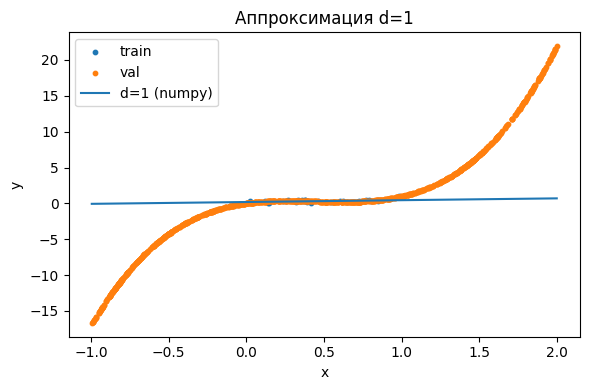

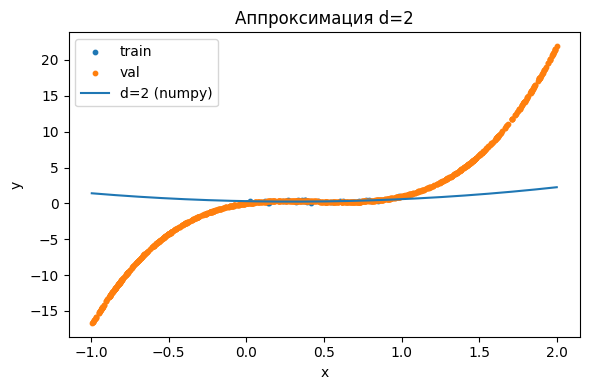

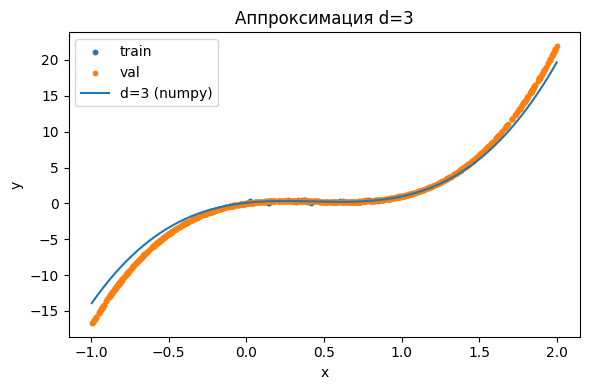

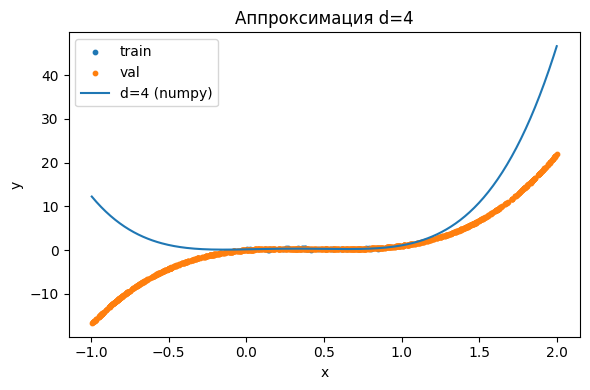

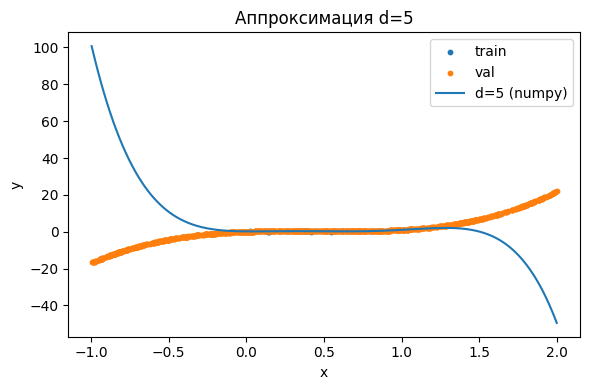

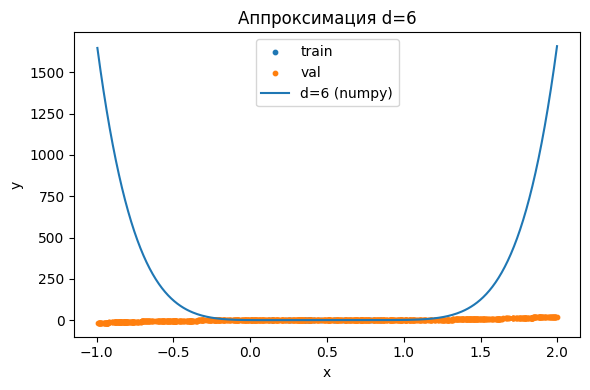

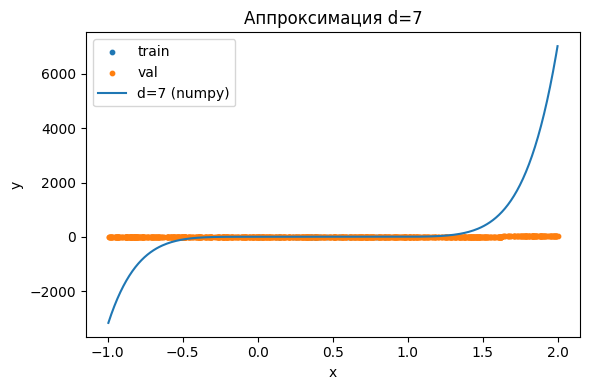

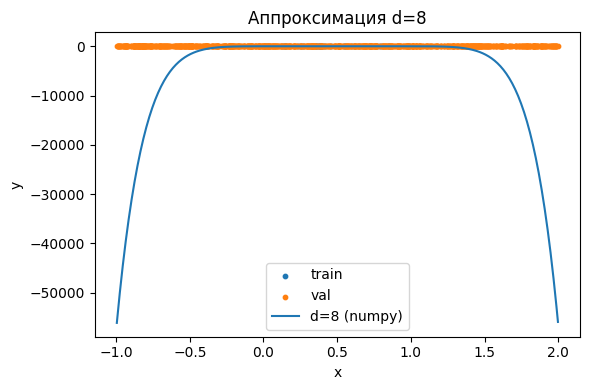

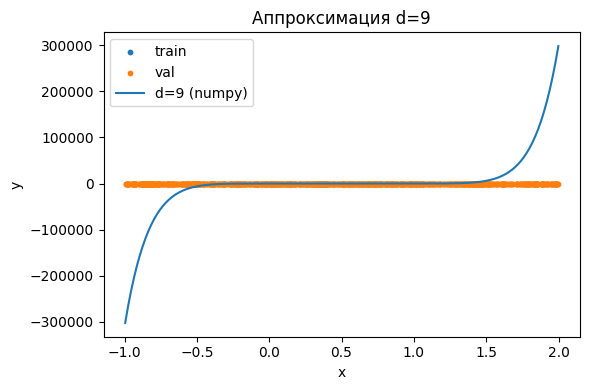

In [ ]:
# Краткие графики: данные + аппроксимация (numpy) по нескольким d
for d in [1,2,3,4,5,6,7,8,9]:
    if ('np',d) not in curves:
        continue
    gx, gy = curves[('np',d)]
    plt.figure(figsize=(6,4))

    plt.scatter(X_train[:,0], y_train, s=10, label='train')
    plt.scatter(X_val[:,0],   y_val,   s=10, label='val')
    plt.plot(gx, gy, label=f'd={d} (numpy)')
    plt.xlabel('x'); plt.ylabel('y'); plt.legend(); plt.title(f'Аппроксимация d={d}')
    plt.tight_layout()
    plt.show()

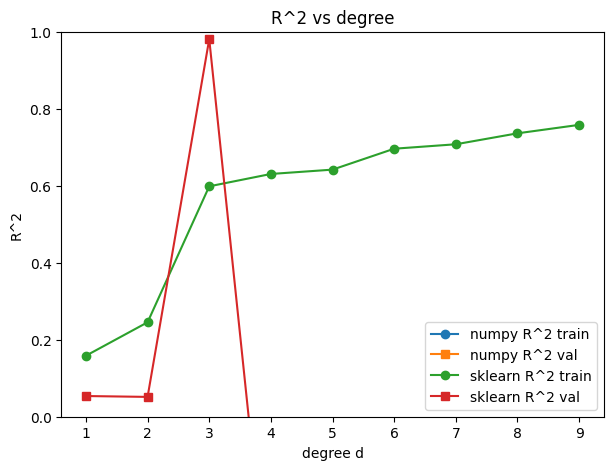

In [ ]:
# Считаем R в квадрате, чем он больше тем лучше
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def r2(a,b):
    a=np.asarray(a); b=np.asarray(b)
    ssr = np.sum((a-b)**2); sst = np.sum((a-np.mean(a))**2)
    return float(1-ssr/sst) if sst>0 else 1.0

degrees = range(1, 10)
r2_np_tr, r2_np_v = [], []
r2_sk_tr, r2_sk_v = [], []

for d in degrees:
    # numpy
    m = NumpyPolyLR(d).fit(X_train, y_train)
    r2_np_tr.append(r2(y_train, m.predict(X_train)))
    r2_np_v .append(r2(y_val,   m.predict(X_val)))
    # sklearn
    pf = PolynomialFeatures(d, include_bias=False)
    Xtr_p = pf.fit_transform(X_train); Xv_p = pf.transform(X_val)
    lr = LinearRegression().fit(Xtr_p, y_train)
    r2_sk_tr.append(r2(y_train, lr.predict(Xtr_p)))
    r2_sk_v .append(r2(y_val,   lr.predict(Xv_p)))

plt.figure(figsize=(7,5))
plt.plot(list(degrees), r2_np_tr, marker='o', label='numpy R^2 train')
plt.plot(list(degrees), r2_np_v,  marker='s', label='numpy R^2 val')
plt.plot(list(degrees), r2_sk_tr, marker='o', label='sklearn R^2 train')
plt.plot(list(degrees), r2_sk_v,  marker='s', label='sklearn R^2 val')
plt.ylim(0, 1)
plt.xlabel('degree d'); plt.ylabel('R^2'); plt.title('R^2 vs degree'); plt.legend(); plt.show()
# масштаб - по y от 0 до 1

## Задача 2.4

Как было упомянуто на лекции, линейные модели требовательны ко входным признакам. В этом упражнении вам предлагается провести собственный эксперимент: соорудить для линейной модели компактный набор признаков, и построить на нём линейную модель.

Подробно описана, проделана и визуализирована первичная обработка данных, исследованы корреляции между признаками (в том числе искуственно созданными), между признаками и метками, сделаны выводы.
<br><br>

[ `round[ 5 * exp(- max{0, n-2} / 3) * (1.0 - min{RMSE, 1.0}) ]` баллов]

На основе анализа данных выбран небольшой поднабор на основе `n` первичных признаков (к которому можно добавить любое количество производных признаков, собранных из этих `n`). Показано, что в совокупности этот набор признаков (включая производные от них) позволяет решить задачу линейной регрессии с `RMSE` на валидационном фрагменте не более `1.0`.

Размер валидационного фрагмента выборки вы можете выбрать самостоятельно в диапазоне от 10% до 90% объектов (разделите исходный тренировочный набор на две части)
<br><br>


[ `round[ 40 * (0.1 - min{RMSE, 0.1}) ]` баллов] RMSE на тестовом фрагменте для лучшей модели не более `0.1`.

In [ ]:
round(5 * np.exp(-max(0, 2-2)/3) * (1.0 - min(0.101464, 1.0)))

4

In [ ]:
round(40 * (0.1 - min(0.010789, 0.1)))

4

In [ ]:
# загрузка данных
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1q49VyL3htV04F64izkn-eywysCqtzlAa' -O dataset.npz

dataset = np.load('dataset.npz', allow_pickle=True)
Xtrain, ytrain, Xtest, ytest = dataset['Xtrain'], dataset['ytrain'], dataset['Xtest'], dataset['ytest']

--2025-10-07 15:50:06--  https://docs.google.com/uc?export=download&id=1q49VyL3htV04F64izkn-eywysCqtzlAa
Resolving docs.google.com (docs.google.com)... 172.217.214.100, 172.217.214.101, 172.217.214.102, ...
Connecting to docs.google.com (docs.google.com)|172.217.214.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1q49VyL3htV04F64izkn-eywysCqtzlAa&export=download [following]
--2025-10-07 15:50:06--  https://drive.usercontent.google.com/download?id=1q49VyL3htV04F64izkn-eywysCqtzlAa&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.152.132, 2607:f8b0:4001:c56::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.152.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16160994 (15M) [application/octet-stream]
Saving to: ‘dataset.npz’

dataset.npz         100%[===================>]  15.41M  --.-KB/s  

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# Загружаем данные
dataset = np.load('dataset.npz', allow_pickle=True)
X_train, y_train = dataset['Xtrain'], dataset['ytrain']
X_test, y_test = dataset['Xtest'], dataset['ytest']

# Масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Поднятие признаков до степени 2
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Формируем DataFrame для удобства
feature_names = poly.get_feature_names_out([f"x{i}" for i in range(X_train.shape[1])])
df = pd.DataFrame(X_train_poly, columns=feature_names)

# Добавляем целевую метку
df["target"] = y_train.ravel()

# Корреляционная матрица
corr_matrix = df.corr()

# Корреляции целевой переменной с признаками
target_corr = corr_matrix["target"].sort_values(key=abs, ascending=False)

print("Корреляционная матрица признаков:")
print(corr_matrix)

print("\nКорреляция признаков с целевой переменной:")
print(target_corr)

Корреляционная матрица признаков:
               x0        x1        x2        x3        x4        x5        x6  \
x0       1.000000 -0.000593  0.001064 -0.013326  0.002552  0.012644 -0.005683   
x1      -0.000593  1.000000  0.000877  0.005215  0.003448 -0.029586  0.018227   
x2       0.001064  0.000877  1.000000 -0.008959  0.007693  0.026297  0.002903   
x3      -0.013326  0.005215 -0.008959  1.000000 -0.008170 -0.029801  0.007959   
x4       0.002552  0.003448  0.007693 -0.008170  1.000000  0.007601  0.019824   
...           ...       ...       ...       ...       ...       ...       ...   
x97 x99 -0.002099 -0.000091  0.003630 -0.002144  0.023972  0.011845  0.005115   
x98^2    0.002353 -0.007470  0.002534  0.015071  0.005898  0.007334 -0.006035   
x98 x99  0.025047 -0.006586  0.007098  0.003785 -0.000821 -0.011975 -0.003162   
x99^2    0.024128 -0.001241  0.002369 -0.004401 -0.000187 -0.002950 -0.023085   
target  -0.008018 -0.016924 -0.005115  0.005461 -0.000743 -0.005604  0.0066

In [ ]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import pandas as pd
import numpy as np

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Строим полином 2 степени
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# Имена новых признаков
feature_names = poly.get_feature_names_out([f"x{i}" for i in range(X_train.shape[1])])

# Собираем в DataFrame
df = pd.DataFrame(X_train_poly, columns=feature_names)
df["target"] = y_train.ravel()

# Корреляции с таргетом
corrs = df.corr()["target"].drop("target").sort_values(key=abs, ascending=False)
print(corrs.head(20))